**Loading and installing packages, data**

In [ ]:
from google.colab import drive
drive.mount('/drive/')
import os
os.chdir('/drive/MyDrive/Colab Notebooks/Tweet_climate')

Mounted at /drive/


In [ ]:
#Installed all packages
!pip install transformers==4.2.2
!pip install pyLDAvis
!pip install gensim
!pip uninstall twint -y
!pip install twint
!pip install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint

In [ ]:
#Imported necessary packages
import csv
import pandas as pd
from datetime import datetime
import numpy as np
import re
import random
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import tensorflow as tf
from scipy.special import softmax
import twint
import nest_asyncio
nest_asyncio.apply()
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import nltk
nltk.download('popular')
from nltk import word_tokenize
from nltk import ngrams
from collections import Counter

**Data Description and Pre-processing**

In [ ]:
#Defined punctuations and stopwords
#Adding few more punctuations and html special entities
from nltk.corpus import stopwords
punctuationlst = list(punctuation)
punctuationlst.append('--') 
punctuationlst.append('-')
punctuationlst.append('..') 
punctuationlst.append('gt')
punctuationlst.append('\n')
punctuationlst.append('amp')

stopwords = stopwords.words("english")
stopwords.append('would')
stopwords.append('should')
stopwords.append('must')
stopwords.append('could')

In [ ]:
#Defined a function to sort needed columns from data files
def dataready(file):
    data = pd.read_csv(file, sep=',', header=None, dtype=str)
    data = data.iloc[:,[2,3,5]].reindex() #Selecting only tweet, date, userid
    data[2] = data[2].apply(lambda x: str(x)[:11]) #Processing date to mm/dd/yy format
    data = data.dropna()
    data = data.rename(columns={2:"Date", 3:"ID", 5:"Tweet"})
    data['Tweet'] = data['Tweet'].astype(str)
    data.drop(index=0,axis=0,inplace=True) 
    return data

#Defined a function to preprocess the words by removing nickname,url, punctuations and stopwords.
def preprocessing(lst):
    preprocessed_lst = []
    regex_url = "@+[0-9a-zA-Z!#$%&'*+-/=?^_`{|}~.]+|http+[0-9a-zA-Z!#$%&'*+-/=?^_`{|}~.:/]+|//t.co/+[0-9a-zA-Z!#$%&'*+-/=?^_`{|}~.:/]+" #remove @nickname(tagging) and urls 
    for sen in range(len(lst)):
      x = re.sub(regex_url, ' ',lst[sen])
      tokenised_sen = word_tokenize(x)
      tokenised_words=[]
      for word in tokenised_sen:
          regex_check = re.match("[a-zA-Z-]+",word.lower()) #Match the words starts with only characters
          if(regex_check!=None):
              if(regex_check.group()==word.lower()) and (word.lower() not in punctuationlst) and (word.lower() not in stopwords):
                tokenised_words.append(word.lower())
      preprocessed_lst.append(' '.join(tokenised_words)) 
    return preprocessed_lst

#Removed the empty strings after preprocessing was finished
def preprocess1(data): 
  tweets = data['Tweet'].to_list()
  dates = data['Date'].to_list()
  for idx, text in enumerate(tweets):
      if 0 <= len(text) < 3:
          del tweets[idx]
          del dates[idx]
  return tweets, dates

**Tweet scraping**

In [ ]:
#Generated dates for twint search
datesgeneration = pd.date_range(start='2017-01-01', end='2022-03-29', freq='3D').tolist()
dates = []
for date in datesgeneration:
    dates.append(str(date))

In [ ]:
#Scraped tweet based on location with keyword 'climate change' 
for date in range(len(dates)-1):
    c = twint.Config()
    c.Search = ["climate change"]
    c.Pandas = True
    c.Geo = "-1.286389, 36.817223, 50km" #changed each time with different location geocoordinates
    c.Since = dates[date]
    c.Until = dates[date+1]
    c.Store_csv = True
    c.Output = "ny_tweets.csv"
    twint.run.Search(c)

/root/.local/lib/python3.7/site-packages/twint/get.py:166: DeprecationWarning: with timeout() is deprecated, use async with timeout() instead
  with timeout(120):


[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


**Reddit scraping**

In [ ]:
!install pmaw
from pmaw import PushshiftAPI

In [ ]:
#Scraped all post under 'climatechange' subreddit category with limit of 50000
api = PushshiftAPI()
posts = api.search_submissions(subreddit="climatechange", limit=50000) #scraping all the post under subreddit 'climatechange'
post_list = [post for post in posts]
post_list.to_csv('post_list.csv')

**Data Preparation**

In [ ]:
#Loaded reddit csv file and preprocess it
reddit = pd.read_csv('post_list.csv', dtype=str)
reddits = reddit['body'].to_list()
preprocessed_reddit1 = preprocessing(reddits)

#Removed some deleted/removed posts from dataset
removelst = ['deleted','removed']
preprocessed_reddits = []

for text in preprocessed_reddit1:
  if text not in removelst:
    preprocessed_reddits.append(text)

In [ ]:
#Loaded twitter general file and preprocess it
alltweets = dataready('alltweets.csv')
alltweets_lst = alltweets['Tweet'].to_list()
preprocessed_alltweets = preprocessing(alltweets_lst)
alltweets['Tweet'] = preprocessed_alltweets
preprocessed_alltweets = preprocess1(alltweets)[0]

#Loaded twitter regional fiels and preprocess it
usdata = dataready('usdata_clean.csv')
ukdata = dataready('ukdata_clean.csv')
bzdata = dataready('bzdata_clean.csv')
jpdata = dataready('jpdata_clean.csv')
frdata = dataready('frdata_clean.csv')
iddata = dataready('iddata_clean.csv')

twitter_regional = pd.concat([usdata, ukdata,bzdata,jpdata,frdata,iddata], axis=0)

In [ ]:
#Removed empty string for both datasets
for index, value in enumerate(preprocessed_reddits):
     if value == '':
       del preprocessed_reddits[index]

for index, value in enumerate(preprocessed_alltweets):
     if value == '':
       del preprocessed_alltweets[index]

In [ ]:
#printed examples of preprocessed dataset
print('Reddit example','\n')
print('Before:', reddits[55])
print('After:', preprocessed_reddits[55],'\n')
print('\t')
print('Tweet example:','\n')
print('Before:', alltweets_lst[5])
print('After:', preprocessed_alltweets[5])
print('\n')
print('Reddit data size: ', len(preprocessed_reddits))
print('Tweet data size: ', len(preprocessed_alltweets))
print('\n')

def averageSentence(data):
    words = (' '.join(data)).split()
    average = sum(len(word) for word in words)/len(data)
    return average

#Checked average sentence size for each dataset
avg_tweet = averageSentence(preprocessed_alltweets)
avg_reddit = averageSentence(preprocessed_reddits)

print('Tweet average sentence size:', avg_tweet)
print('Reddit average sentence size:', avg_reddit)

Reddit example 

Before: &gt; Depending on where you live

The only thing this is going to change is HOW it affects you. As coastal cities flood and the equator desertifies, hundreds of millions of people will be fleeing to the places that remain inhabitable, which will cause an even greater housing crisis in those areas, among MANY other issues that panicked mass immigration of that immense scale would lead to.
After: absolute latest sooner efforts curb climate change continued dodged short-sighted boomer politicians current trend means see roughly global increase cause basically permanent global famine track increase likely around point seeing desertification equator including united states leaving people flee hundreds millions places remain inhabitable 

	
Tweet example: 

Before: @MeghanMcCain Who was it that said climate change is not an issue that is on the radar of most Americans? Why the theatrics for what you described as a non-issue, sinply because it ruined your vacation spo

**Text analysis - Term Frequency Analaysis**

In [ ]:
#Joined all sentences to one large sentence for text analysis
joinedtweets = ' '.join(preprocessed_alltweets)
joinedreddits = ' '.join(preprocessed_reddits)

In [ ]:
#Made dictionaries for each dataset and count the most commonly used unigram(top 30)
allwords_tweet = nltk.tokenize.word_tokenize(joinedtweets)
TweetWordDist = nltk.FreqDist(w.lower() for w in allwords_tweet)

allwords_reddit = nltk.tokenize.word_tokenize(joinedreddits)
RedditWordDist = nltk.FreqDist(w.lower() for w in allwords_reddit)

Tweet30wordlst = TweetWordDist.most_common(30)
Reddit30wordlst = RedditWordDist.most_common(30)

In [ ]:
#sorted lists for visualization
Tweet30word = []
Tweet30word_count = []
Reddit30word = []
Reddit30word_count = []

for keys in Tweet30wordlst:
  Tweet30word.append(keys[0])
  Tweet30word_count.append(keys[1])

for keys in Reddit30wordlst:
  Reddit30word.append(keys[0])
  Reddit30word_count.append(keys[1])

In [ ]:
#Checked common words used on both platform and difference
common = set(Tweet30word).intersection(set(Reddit30word))
print('common words used', ', '.join(common))

onlytweet = set(Tweet30word) - common
print('words used only on twitter',', '.join(onlytweet))

onlyreddit = set(Reddit30word) - common
print('words used only on reddit',', '.join(onlyreddit))

common words used us, energy, change, time, make, need, see, world, global, climate, think, know, years, going, carbon, like, one, much, also, people, earth, get
words used only on twitter via, new, want, action, climatechange, real, environment, help
words used only on reddit temperature, water, data, emissions, warming, even, science, good


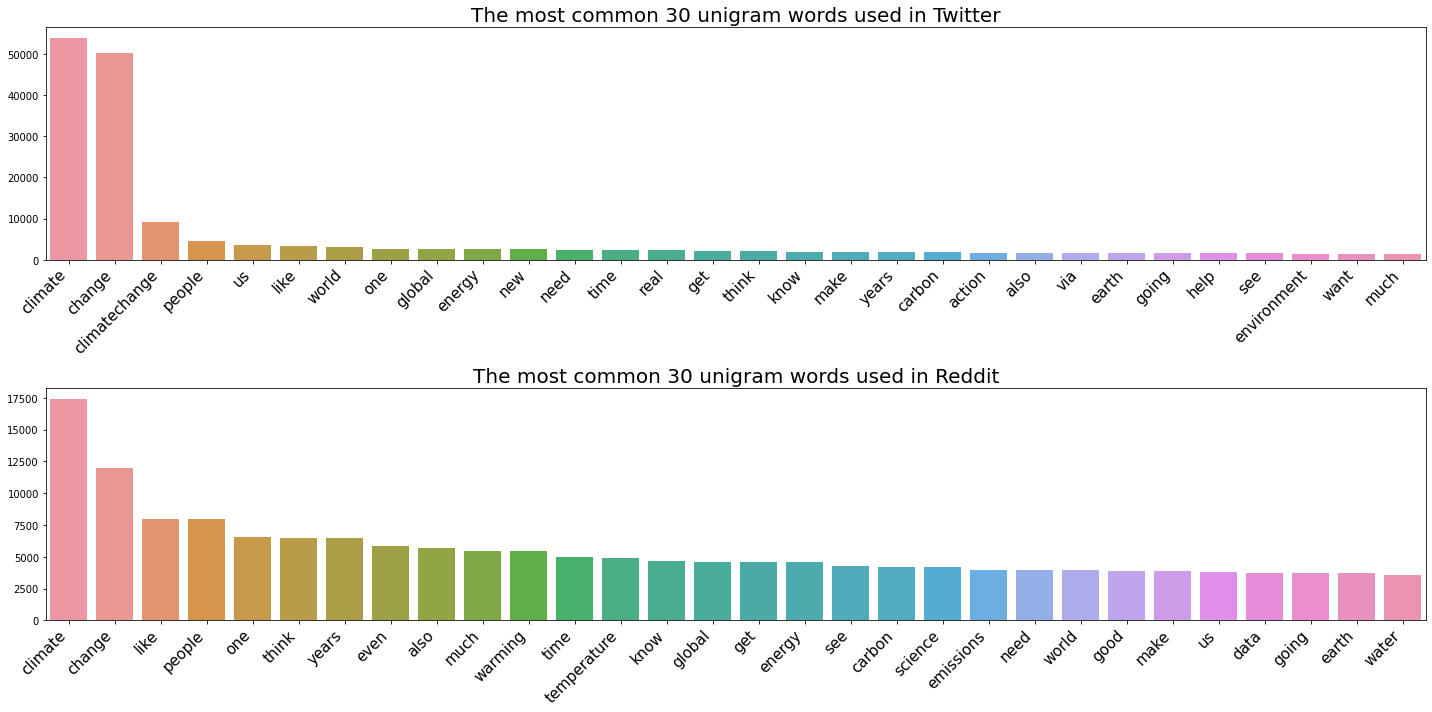

In [ ]:
#Visualization for unigram
fig, axes = plt.subplots(2,1, figsize=(20,10))

sns.barplot(x =Tweet30word, y =Tweet30word_count, ax=axes[0])
axes[0].set_xticklabels(Tweet30word,rotation=45, ha="right",fontsize=15)
axes[0].set_title('The most common 30 unigram words used in Twitter', fontsize=20)
sns.barplot(x = Reddit30word, y= Reddit30word_count,ax=axes[1])
axes[1].set_xticklabels(Reddit30word,rotation=45, ha="right",fontsize=15)
axes[1].set_title('The most common 30 unigram words used in Reddit', fontsize=20)
plt.tight_layout()
plt.show()

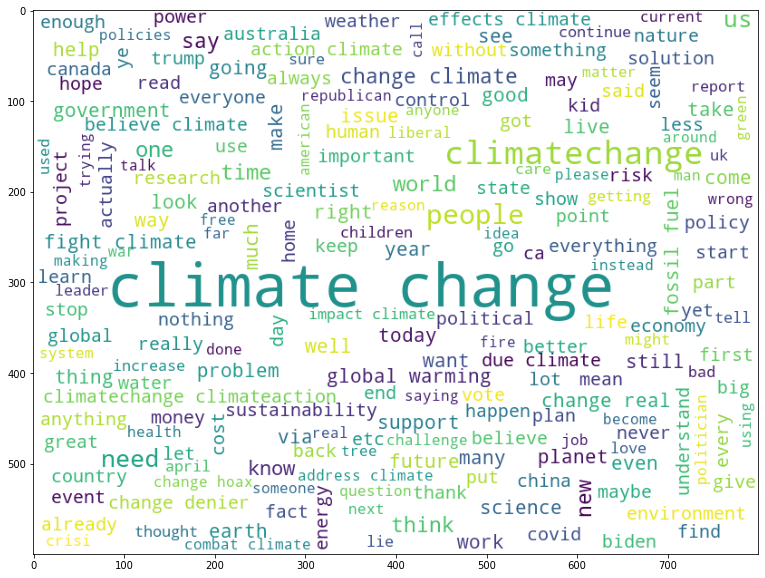

In [ ]:
#word-cloud for twitter
plt.figure(figsize = (20,10))
tweet_wordcloud = WordCloud(background_color='white',width=800, height=600)
tweetimg=tweet_wordcloud.generate(joinedtweets)
plt.savefig('tweetimg.png')
plt.imshow(tweet_wordcloud)

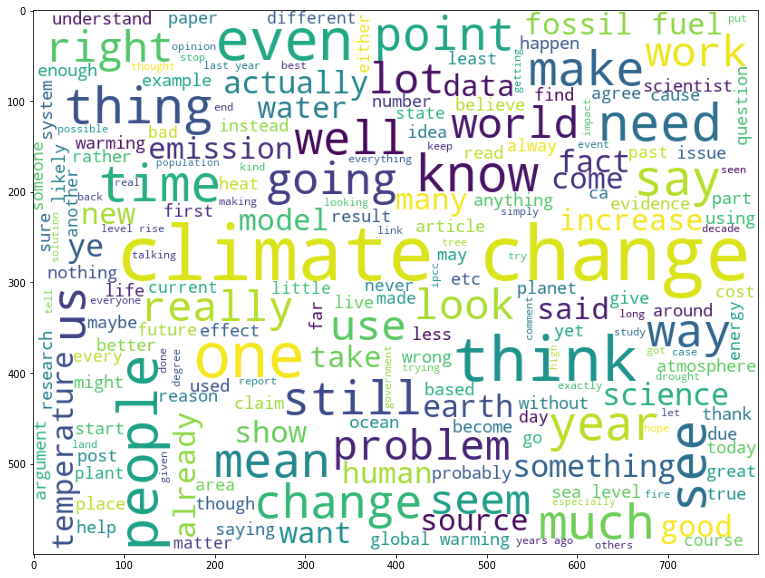

In [ ]:
#Wordcloud for reddit
plt.figure(figsize = (20,10))
redit_wordcloud = WordCloud(background_color='white',width=800, height=600)
redit_wordcloud.generate(joinedreddits)
plt.imshow(redit_wordcloud)

In [ ]:
#Defined function for bigram and trigram analysis
def bigram(sen):
  n = 2
  n_grams = ngrams(sen.split(),n)
  n_grams_count = Counter(n_grams)
  return n_grams_count.most_common(100)

def trigram(sen):
  n = 3
  n_grams = ngrams(sen.split(),n)
  n_grams_count = Counter(n_grams)
  return n_grams_count.most_common(100)

tweet_bigram_mostcommon = bigram(joinedtweets)
tweet_trigram_mostcommon = trigram(joinedtweets)
reddit_bigram_mostcommon = bigram(joinedreddits)
reddit_trigram_mostcommon = trigram(joinedreddits)

In [ ]:
#sorted the list for item and values for visualization
Tweet_bigram_30word = []
Tweet_bigram_30word_count = []
Reddit_bigram_30word = []
Reddit_bigram_30word_count = []

for keys in tweet_bigram_mostcommon[:31]:
  Tweet_bigram_30word.append(' '.join(keys[0]))
  Tweet_bigram_30word_count.append(keys[1])

for keys in reddit_bigram_mostcommon[:31]:
  Reddit_bigram_30word.append(' '.join(keys[0]))
  Reddit_bigram_30word_count.append(keys[1])

In [ ]:
#checked common words for both platforms and difference
common_bigram = set(Tweet_bigram_30word).intersection(set(Reddit_bigram_30word))
print('Common bigrams used on both platform:',', '.join(common_bigram))

onlytweet_bigram = set(Tweet_bigram_30word) - common_bigram
print('Bigrams used only on Twitter:',', '.join(onlytweet_bigram))

onlyreddit_bigram = set(Reddit_bigram_30word) - common_bigram
print('Bigrams used only on Reddit:',', '.join(onlyreddit_bigram))

Common bigrams used on both platform: gon na, fossil fuel, climate change, fossil fuels, global warming
Bigrams used only on Twitter: address climate, change climate, stop climate, global climate, change real, action climate, like climate, climate crisis, climatechange climate, think climate, combat climate, tackle climate, climatechange climateaction, climate changes, impacts climate, fighting climate, believe climate, climate action, change global, fight climate, due climate, impact climate, change hoax, change deniers, change via, effects climate
Bigrams used only on Reddit: years ago, level rise, greenhouse gases, many people, water vapor, sea level, every year, long term, greenhouse gas, sea ice, ice age, million years, past years, carbon capture, seems like, last years, global temperature, extreme weather, per year, et al, climate models, greenhouse effect, climate scientists, nuclear power, carbon dioxide, climate science


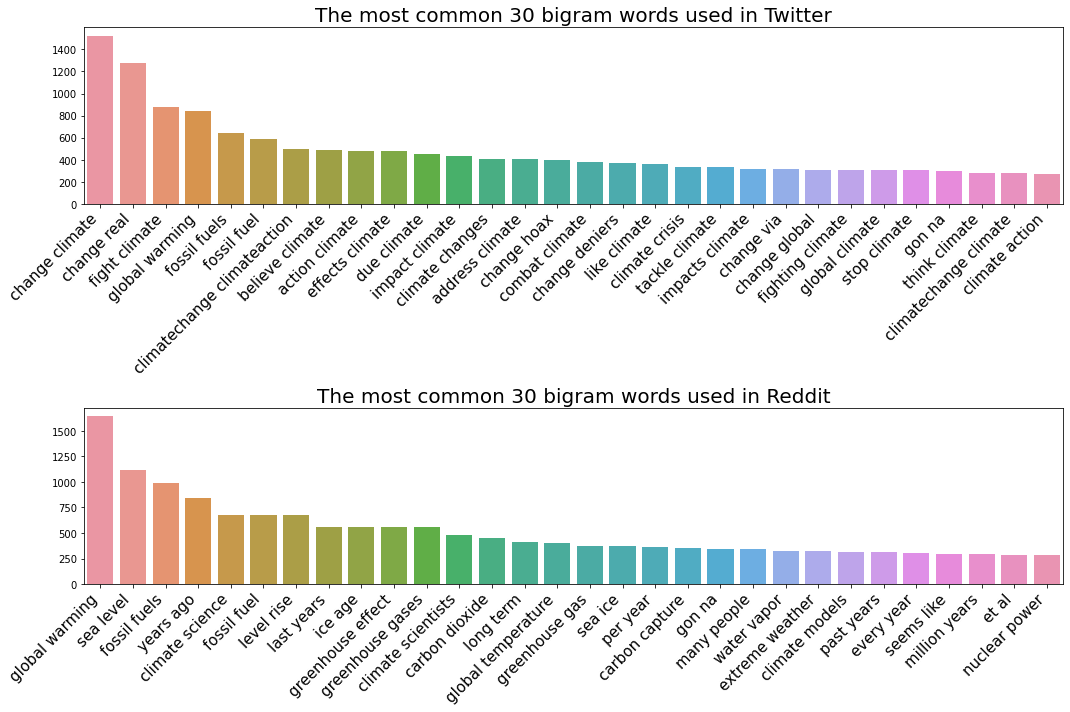

In [ ]:
#Bigram analysis visualization
fig, axes = plt.subplots(2,1, figsize=(15,10))
sns.barplot(x =Tweet_bigram_30word[1:], y =Tweet_bigram_30word_count[1:], ax=axes[0])
axes[0].set_xticklabels(Tweet_bigram_30word[1:],rotation=45, ha="right", fontsize=15)
axes[0].set_title('The most common 30 bigram words used in Twitter', fontsize=20)
sns.barplot(x = Reddit_bigram_30word[1:], y= Reddit_bigram_30word_count[1:],ax=axes[1])
axes[1].set_xticklabels(Reddit_bigram_30word[1:],rotation=45, ha="right", fontsize=15)
axes[1].set_title('The most common 30 bigram words used in Reddit', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
#sorted the list for item and values for visualization
Tweet_trigram_30word = []
Tweet_trigram_30word_count = []
Reddit_trigram_30word = []
Reddit_trigram_30word_count = []

for keys in tweet_trigram_mostcommon[:31]:
  Tweet_trigram_30word.append(' '.join(keys[0]))
  Tweet_trigram_30word_count.append(keys[1])

for keys in reddit_trigram_mostcommon[:31]:
  Reddit_trigram_30word.append(' '.join(keys[0]))
  Reddit_trigram_30word_count.append(keys[1])

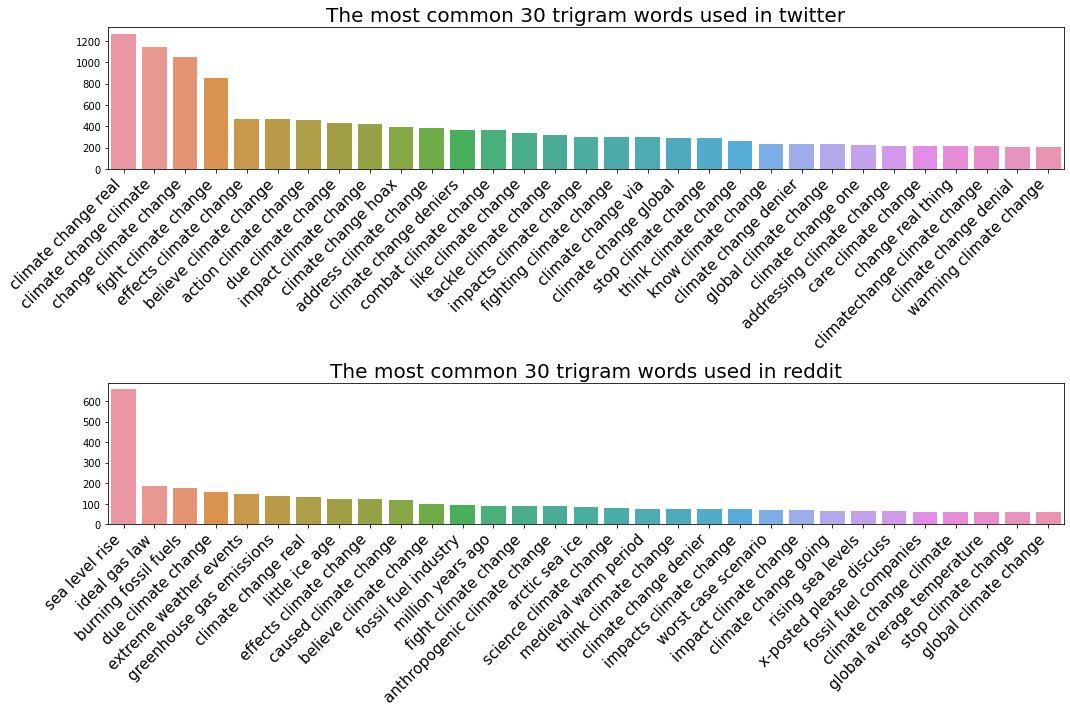

In [ ]:
#trigram analysis visualization
fig, axes = plt.subplots(2,1, figsize=(15,10))
sns.barplot(x =Tweet_trigram_30word, y =Tweet_trigram_30word_count, ax=axes[0])
axes[0].set_xticklabels(Tweet_trigram_30word,rotation=45, ha="right",fontsize=15)
axes[0].set_title('The most common 30 trigram words used in twitter', fontsize=20)
sns.barplot(x = Reddit_trigram_30word, y= Reddit_trigram_30word_count,ax=axes[1])
axes[1].set_xticklabels(Reddit_trigram_30word,rotation=45, ha="right",fontsize=15)
axes[1].set_title('The most common 30 trigram words used in reddit', fontsize=20)
plt.tight_layout()
plt.show()

**Time Series Analysis**

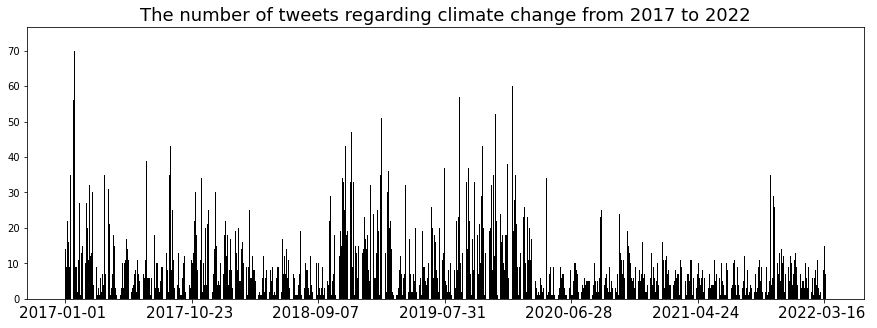

In [ ]:
twitter_regional.sort_values(by='Date')
tweetincrementdf = twitter_regional.groupby('Date').count()['Tweet']
date = tweetincrementdf.index[:-6]
value = tweetincrementdf.values[:-6]
years = ['2017','2018','2019','2020','2021','2022']
xtick = np.linspace(0, 6 , 1)
plt.figure(figsize=(15,5))
plt.bar(date, value, color='black')
plt.xticks(range(0, int(len(date)), int(len(date)/6)),fontsize=15)
plt.title('The number of tweets regarding climate change from 2017 to 2022',fontsize=18)
plt.show()

**Sentiment Analysis-Reddit,Twitter General**

In [ ]:
#Sentiment analysis
from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification,AutoTokenizer,AutoConfig
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest" #Loading pre-trained RoBERTa model
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

#Model test on the text 'I love you'
text = "Ilove you"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores).argmax()
scores

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2

In [ ]:
#Tested on Reddit and Tweet datasets
reddit_labels = []
for text in preprocessed_reddits:
  encoded_input = tokenizer(text, return_tensors='pt',truncation=True,max_length=50,padding=True) #max word length set for 50 considering computation time
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  reddit_labels.append(score)
 
tweet_labels = []
for text in preprocessed_alltweets:
  encoded_input = tokenizer(text, return_tensors='pt',truncation=True,max_length=50,padding=True)
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  tweet_labels.append(score)

In [ ]:
#Removed empty string for both datasets
for index, value in enumerate(preprocessed_reddits):
     if value == '':
       del preprocessed_reddits[index]
       del reddit_labels[index]

for index, value in enumerate(preprocessed_alltweets):
     if value == '':
       del preprocessed_alltweets[index]
       del tweet_labels[index]

In [ ]:
#checked each class size and example
print(preprocessed_reddits[356])
print(reddit_labels[356])
print(preprocessed_alltweets[2])
print(tweet_labels[2])

northern hemisphere horrid winters really interesting way put winters include following local climates wildlife areas adapted live wo anywhere go order maintain living conditions meaning massive loss biodiversity lose annual cooling periods allow polar ice re-form helps regulate climate prevent warming scenario lose total control well helping keep sea levels consistent enough cold kill lot pests otherwise carry diseases crops wildlife recreational areas especially mosquito-related diseases tropics like malaria zika predictably frozen land far-northern areas allowed us build roads used transport things like interestingly enough oil starting become unusable permafrost stores massive amounts greenhouse gases extremely harmful human life forms released atmosphere even mention northern hemisphere also vulnerable sorts summer heat-related impacts like forest fires dry spells simply heat humidity high enough kill otherwise healthy people severly hamper agriculture also sure mean sahara gettin

In [ ]:
#Defined the label and count value for visualization
reddit_counter=Counter(reddit_labels)
twitter_counter =Counter(tweet_labels)
reddit_value = list(reddit_counter.values())
reddit_counts = list(reddit_counter.keys())
tweet_value = list(twitter_counter.values())
tweet_counts = list(twitter_counter.keys())

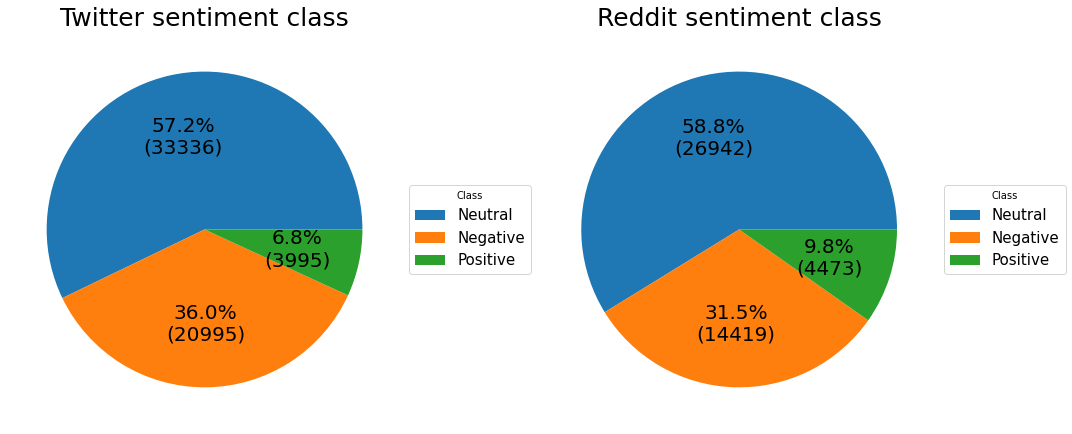

In [ ]:
#Sentiment analysis visualization
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 15))

label = ['Neutral','Negative','Positive']
wedges, texts, autotexts = ax1.pie(tweet_value, autopct=lambda pct: func(pct, tweet_value), textprops={'fontsize': 20})
ax1.legend(wedges, label,
          title="Class",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=15)
ax1.set_title("Twitter sentiment class", fontsize=25)


wedges, texts, autotexts = ax2.pie(reddit_value, autopct=lambda pct: func(pct, reddit_value), textprops={'fontsize': 20})
ax2.legend(wedges, label,
          title="Class",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),fontsize=15)

ax2.set_title("Reddit sentiment class", fontsize=25)

plt.tight_layout()
plt.show()

In [ ]:
#Created dataframe for twitter and reddit dataset with their sentiment classes
pd.options.display.max_colwidth = 500
tweetdf = pd.DataFrame({'Tweet':preprocessed_alltweets, 'Tweet label':tweet_labels})
redditdf = pd.DataFrame({'Reddit':preprocessed_reddits, 'Reddit label':reddit_labels})
tweetdf.dropna(axis = 1, how ='any',inplace=True)
redditdf.dropna(axis = 1, how ='any',inplace=True)

In [ ]:
#sorted examples for neutral tweets
tweetdf.loc[tweetdf['Tweet label'] == 1].head()

,Tweet,Tweet label
0,food crisis opportunity help educate audiences interested climate change often still grasp irrefutable necessity solutions,1
1,moccae organises first conference uae climate change research network menaclimateweek uaeforclimate,1
4,video climate change protest austria,1
6,apart totally ok childless pursue things human race may actually survive parts either climate change pandemics etc require principled intelligent people science politics etc people might women,1
8,believe climate change,1


In [ ]:
#sorted examples for positive tweets
tweetdf.loc[tweetdf['Tweet label'] == 2].head()

,Tweet,Tweet label
36,great mckenna still game important work keeping sub-sovereign entities accountable commitments fight climate change given global reach nobody finer pursue important work,2
43,fight climatechange adding trees environment nice work los angeles constructive progress rather fictitious carbon tax world economic forum,2
49,good thing climate change,2
55,drop hottest immersive climate change escape room experience ever seen,2
58,rooting crab makers climate change oil gas companies seen good read graphics aksnowcrabs important akleg,2


In [ ]:
#sorted examples for negative tweets
tweetdf.loc[tweetdf['Tweet label'] == 0].head()

,Tweet,Tweet label
2,wealthy countries united states canada germany belgium joining poorer vulnerable nations growing list extreme weather events scientists say connection human-caused climate change,0
3,remember hearing argument portraying climate change sudden collapse mad max ends distracting likely scenario shit gets shitter gradually awful lot people life goes end anything,0
5,said climate change issue radar americans theatrics described non-issue sinply ruined vacation spot,0
7,climate change called super-wicked problem going solved managed less well,0
11,good lord get new shtick-please tired predictable even degrees canadians care climate change also rebates boring climatecrisis,0


In [ ]:
#sorted examples for netrual reddit post
redditdf.loc[redditdf['Reddit label'] == 1].head()

In [ ]:
#sorted examples for positive reddit post
redditdf.loc[redditdf['Reddit label'] == 2].head()

,Reddit,Reddit label
4,higher concentration good plants,2
21,mammals flourished hottest period earth history,2
39,idea around airships makes sooo much sense idea case interested,2
41,get good news,2
46,first important goal always reduction carbon emissions become viable lucrative transportation companies easy install cheap buy implemented right make carbon capture technology much efficient implemented like many new green technologies companies buy advertising reasons forget,2


In [ ]:
#sorted examples for negative reddit post
redditdf.loc[redditdf['Reddit label'] == 0].head()

**Regional analysis**

In [ ]:
#Prepared regional dataset
uktweets = preprocess1(ukdata)[0]
ukdates = preprocess1(ukdata)[1]
ustweets = preprocess1(usdata)[0]
usdates = preprocess1(usdata)[1]
jptweets = preprocess1(jpdata)[0]
jpdates = preprocess1(jpdata)[1]
bztweets = preprocess1(bzdata)[0]
bzdates = preprocess1(bzdata)[1]
idtweets = preprocess1(iddata)[0]
iddates = preprocess1(iddata)[1]
frtweets = preprocess1(frdata)[0]
frdates = preprocess1(frdata)[1]

In [ ]:
processed_uktweets = preprocessing(uktweets)
processed_ustweets = preprocessing(ustweets) 
processed_jptweets = preprocessing(jptweets)
processed_bztweets = preprocessing(bztweets) 
processed_frtweets = preprocessing(frtweets) 
processed_idtweets = preprocessing(idtweets) 

In [ ]:
print(len(processed_uktweets))
print(len(ukdates))
print(len(processed_ustweets))
print(len(usdates))
print(len(processed_bztweets))
print(len(bzdates))
print(len(processed_jptweets))
print(len(jpdates))
print(len(processed_frtweets))
print(len(frdates))
print(len(processed_idtweets))
print(len(iddates))

print(len(processed_uktweets)+len(processed_ustweets)+len(processed_bztweets)+
      len(processed_jptweets)+len(processed_frtweets)+len(processed_idtweets))

6958
6958
7913
7913
66
66
94
94
877
877
1819
1819
17727


**Sentiment Analysis - Regional**

In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification,AutoTokenizer,AutoConfig

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

text = "Ilove you"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores).argmax()
scores

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2

In [ ]:
x_train_bz = processed_bztweets
x_train_us = processed_ustweets
x_train_uk = processed_uktweets
x_train_fr = processed_frtweets
x_train_jp = processed_jptweets
x_train_id = processed_idtweets

In [ ]:
#RoBERTa model implementation for each country
us_labels = []
for text in x_train_us:
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  us_labels.append(score)

uk_labels = []
for text in x_train_uk:
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  uk_labels.append(score)

bz_labels = []
for text in x_train_bz:
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  bz_labels.append(score)  

id_labels = []
for text in x_train_id:
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  id_labels.append(score)

jp_labels = []
for text in x_train_jp:
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  jp_labels.append(score)

fr_labels = []
for text in x_train_fr:

  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  score = softmax(scores).argmax()
  fr_labels.append(score)


In [ ]:
#Examples of sentiment analysis result
print('UK example:', x_train_uk[400], 'Label:', uk_labels[400])
print('US example:', x_train_us[400], 'Label:', uk_labels[400])

UK example: clueless guy climate like without human caused climate change pls idiocy Label: 0
US example: hope reporters talk make point ask climate change kentuckians suffering denial science contributed tragedy Label: 0


In [ ]:
#Data preparation for visualization
us_sentimentdf = pd.DataFrame({'Date': usdates, 'Tweets': processed_ustweets,'Label': us_labels})
uk_sentimentdf = pd.DataFrame({'Date': ukdates, 'Tweets': processed_uktweets,'Label': uk_labels})
jp_sentimentdf = pd.DataFrame({'Date': jpdates, 'Tweets': processed_jptweets,'Label': jp_labels})
bz_sentimentdf = pd.DataFrame({'Date': bzdates, 'Tweets': processed_bztweets,'Label': bz_labels})
fr_sentimentdf = pd.DataFrame({'Date': frdates, 'Tweets': processed_frtweets,'Label': fr_labels})
id_sentimentdf = pd.DataFrame({'Date': iddates, 'Tweets': processed_idtweets,'Label': id_labels})

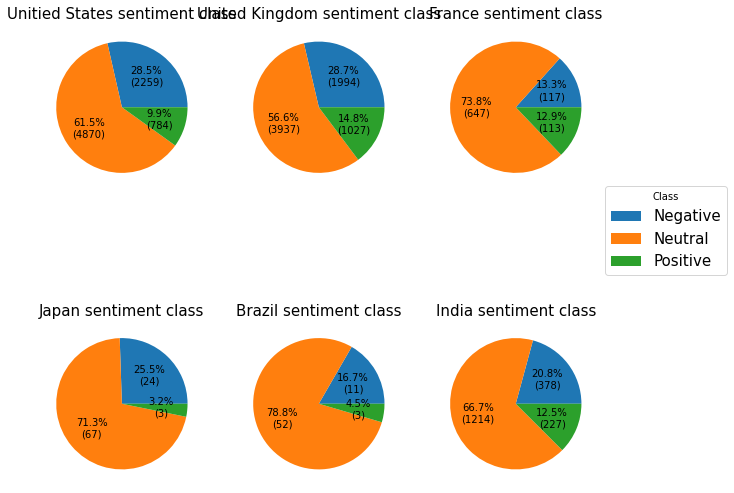

In [ ]:
#Checking class distribtuion for all datasets using piecharts.
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

common_label = ['Negative','Neutral','Positive']
us_ratio = us_sentimentdf.groupby(['Label']).count()['Tweets'].to_list()
uk_ratio = uk_sentimentdf.groupby(['Label']).count()['Tweets'].to_list()
fr_ratio = fr_sentimentdf.groupby(['Label']).count()['Tweets'].to_list()
jp_ratio = jp_sentimentdf.groupby(['Label']).count()['Tweets'].to_list()
bz_ratio = bz_sentimentdf.groupby(['Label']).count()['Tweets'].to_list()
id_ratio = id_sentimentdf.groupby(['Label']).count()['Tweets'].to_list()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(10, 10))
wedges, texts, autotexts = ax1.pie(us_ratio, autopct=lambda pct: func(pct, us_ratio),
                                  textprops=dict(color="black"))

ax1.set_title("Unitied States sentiment class", fontsize=15)

wedges, texts, autotexts = ax2.pie(uk_ratio, autopct=lambda pct: func(pct, uk_ratio),
                                  textprops=dict(color="black"))

ax2.set_title("United Kingdom sentiment class", fontsize=15)

wedges, texts, autotexts = ax3.pie(fr_ratio, autopct=lambda pct: func(pct, fr_ratio),
                                  textprops=dict(color="black"))
ax3.legend(wedges, common_label,
          title="Class",
          loc="center left",
          bbox_to_anchor=(1, 0, 0, -0.5), fontsize=15)
ax3.set_title("France sentiment class", fontsize=15)

wedges, texts, autotexts = ax4.pie(jp_ratio, autopct=lambda pct: func(pct, jp_ratio),
                                  textprops=dict(color="black"))

ax4.set_title("Japan sentiment class", fontsize=15)

wedges, texts, autotexts = ax5.pie(bz_ratio, autopct=lambda pct: func(pct, bz_ratio),
                                  textprops=dict(color="black"))

ax5.set_title("Brazil sentiment class", fontsize=15)

wedges, texts, autotexts = ax6.pie(id_ratio, autopct=lambda pct: func(pct, id_ratio),
                                  textprops=dict(color="black"))
ax6.set_title("India sentiment class", fontsize=15)
plt.setp(autotexts, size=10)
plt.show()

**Latent Dirichlet allocation**

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import TfidfModel

In [ ]:
#Lematized the texts for LDA analysis
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def lematization(data):
  lemmatized_data = []
  for sentence in data:
    word_list = word_tokenize(sentence)
    new_word = []
    for word in word_list:
      if word not in stopwords:
        new = lemmatizer.lemmatize(word)
        new_word.append(new)
    final = ' '.join(new_word)
    lemmatized_data.append(final)
  return lemmatized_data

lemmatized_tweet = lematization(preprocessed_alltweets)
lemmatized_reddit = lematization(preprocessed_reddits)

In [ ]:
#Performed additional simple preprocess using gensim
def gen_words(texts):
  newtexts = []
  for text in texts:
    new = gensim.utils.simple_preprocess(text, deacc=True)
    newtexts.append(new)
  return newtexts

gen_procesed_tweet = gen_words(lemmatized_tweet)
gen_procesed_reddit = gen_words(lemmatized_reddit)

In [ ]:
#Including Bigram and Trigram to the corpus for LDA analysis
bigrams_phrases_tweet = gensim.models.Phrases(gen_procesed_tweet, min_count=3, threshold=300)
trigram_phrases_tweet = gensim.models.Phrases(bigrams_phrases_tweet[gen_procesed_tweet], threshold=300)

bigram_tweet = gensim.models.phrases.Phraser(bigrams_phrases_tweet)
trigram_tweet = gensim.models.phrases.Phraser(trigram_phrases_tweet)

bigrams_phrases_reddit = gensim.models.Phrases(gen_procesed_reddit, min_count=3, threshold=300)
trigram_phrases_reddit = gensim.models.Phrases(bigrams_phrases_reddit[gen_procesed_reddit], threshold=300)

bigram_reddit = gensim.models.phrases.Phraser(bigrams_phrases_reddit)
trigram_reddit = gensim.models.phrases.Phraser(trigram_phrases_reddit)

def make_bigrams(texts,bigram):
  return ([bigram[doc] for doc in texts])

def make_trigrams(texts,bigram,trigram):
  return ([trigram[bigram[doc]] for doc in texts])

tweet_bigrams = make_bigrams(gen_procesed_tweet,bigram_tweet)
tweet_bigrams_trigram = make_trigrams(tweet_bigrams,bigram_tweet,trigram_tweet)

reddit_bigrams = make_bigrams(gen_procesed_reddit,bigram_reddit)
reddit_bigrams_trigram = make_trigrams(reddit_bigrams,bigram_reddit,trigram_reddit)



In [ ]:
#Preparing corpus including bigram, trigram but removing the words with low tf-idf scores.
id2word_tweet = corpora.Dictionary(tweet_bigrams_trigram)
texts_tweet =  tweet_bigrams_trigram
corpus_tweet = [id2word_tweet.doc2bow(text) for text in texts_tweet]

tfidf_tweet = TfidfModel(corpus_tweet, id2word=id2word_tweet)
low_value = 0.05
words_tweet = []
words_missing_in_tfidf_tweet = []

for i in range(0, len(corpus_tweet)):
    bow_tweet = corpus_tweet[i]
    low_value_words_tweet = [] 
    tfidf_ids_tweet = [id for id, value in tfidf_tweet[bow_tweet]]
    bow_ids_tweet = [id for id, value in bow_tweet]
    low_value_words_tweet = [id for id, value in tfidf_tweet[bow_tweet] if value < low_value]
    words_missing_in_tfidf_tweet = [id for id in bow_ids_tweet if id not in tfidf_ids_tweet] # The words with tf-idf socre 0 will be missing
    new_bow_tweet = [b for b in bow_tweet if b[0] not in low_value_words_tweet and b[0] not in words_missing_in_tfidf_tweet]  
    corpus_tweet[i] = new_bow_tweet

id2word_reddit = corpora.Dictionary(reddit_bigrams_trigram)
texts_reddit =  reddit_bigrams_trigram
corpus_reddit = [id2word_reddit.doc2bow(text) for text in texts_reddit]

tfidf_reddit = TfidfModel(corpus_reddit, id2word=id2word_reddit)
words_reddit = []
words_missing_in_tfidf_reddit = []

for i in range(0, len(corpus_reddit)):
    bow_reddit = corpus_reddit[i]
    low_value_words_reddit = [] 
    tfidf_ids_reddit = [id for id, value in tfidf_reddit[bow_reddit]]
    bow_ids_reddit = [id for id, value in bow_reddit]
    low_value_words_reddit = [id for id, value in tfidf_reddit[bow_reddit] if value < low_value]
    words_missing_in_tfidf_reddit = [id for id in bow_ids_reddit if id not in tfidf_ids_reddit] # The words with tf-idf socre 0 will be missing
    new_bow_reddit = [b for b in bow_reddit if b[0] not in low_value_words_reddit and b[0] not in words_missing_in_tfidf_reddit]  
    corpus_reddit[i] = new_bow_reddit

In [ ]:
#fitted LDA model into Twitter and Reddit dataset
lda_model_tweet = gensim.models.ldamodel.LdaModel(corpus=corpus_tweet, 
                                                  id2word=id2word_tweet,
                                                  num_topics=10, 
                                                  random_state=42,
                                                  update_every=1,
                                                  chunksize=100,
                                                  passes=10,
                                                  alpha="auto")
lda_model_reddit = gensim.models.ldamodel.LdaModel(corpus=corpus_reddit, 
                                                   id2word=id2word_reddit,
                                                   num_topics=10, 
                                                   random_state=42,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha="auto")

In [ ]:
#Visulized topic modeling for Twitter
pyLDAvis.enable_notebook()
vis_tweet = pyLDAvis.gensim_models.prepare(lda_model_tweet, corpus_tweet, id2word_tweet)
vis_tweet

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.402834 -0.005291       1        1  14.441865
5      0.054168 -0.380220       2        1  12.274742
7      0.054490  0.136012       3        1  10.756847
2      0.054776  0.071958       4        1  10.487256
1      0.036874  0.033508       5        1   9.624855
9      0.043893  0.034494       6        1   9.523525
8      0.040393  0.031757       7        1   8.763584
3      0.041414  0.028681       8        1   8.742983
0      0.039685  0.026609       9        1   8.738327
4      0.037141  0.022492      10        1   6.646018, topic_info=               Term         Freq        Total Category  logprob  loglift
111   climatechange  9030.000000  9030.000000  Default  30.0000  30.0000
59           people  3904.000000  3904.000000  Default  29.0000  29.0000
645            like  2926.000000  2926.000000  Default  28.0000  28.0000
317          global  2646.000000  2646.000000  Default  27.0000  27.0000
194            need  2761.000000  2761.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
179      republican   327.583393   328.418110  Topic10  -5.0020   2.7086
352          reason   313.156458   313.991128  Topic10  -5.0470   2.7085
3803           bank   303.454696   304.289391  Topic10  -5.0785   2.7084
167           check   299.367257   300.201909  Topic10  -5.0921   2.7084
2507         member   267.637764   268.472439  Topic10  -5.2041   2.7080

[330 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
189       7  0.998006         act
865       4  0.999644      action
80        1  0.998460    actually
893       6  0.998788  adaptation
410       5  0.999469     address
...     ...       ...         ...
326       1  0.999166        work
115       2  0.999613       world
906       9  0.999262       worse
239       2  0.999742        year
538       1  0.999302         yes

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 3, 2, 10, 9, 4, 1, 5])

In [ ]:
#Visualized topic modeling for Reddit
pyLDAvis.enable_notebook()
vis_reddit = pyLDAvis.gensim_models.prepare(lda_model_reddit, corpus_reddit, id2word_reddit)
vis_reddit

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.248740  0.308353       1        1  17.199439
5      0.099077 -0.256044       2        1  12.928335
3      0.123100 -0.089557       3        1  12.031296
2      0.211497 -0.105957       4        1  11.980678
0     -0.126728  0.139338       5        1  11.458208
8     -0.082173  0.108368       6        1   9.798568
4     -0.015994 -0.052510       7        1   8.469975
9     -0.148328 -0.036705       8        1   8.024201
1     -0.160878 -0.009058       9        1   4.516686
7     -0.148313 -0.006229      10        1   3.592614, topic_info=             Term          Freq         Total Category  logprob  loglift
1         climate  14590.000000  14590.000000  Default  30.0000  30.0000
0          change  11550.000000  11550.000000  Default  29.0000  29.0000
98           year   5673.000000   5673.000000  Default  28.0000  28.0000
481   temperature   5621.000000   5621.000000  Default  27.0000  27.0000
306           one   5060.000000   5060.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
2248       choice    269.034840    269.901972  Topic10  -5.1289   3.3231
2277         role    262.347097    263.214264  Topic10  -5.1540   3.3230
1605    reference    260.436721    261.303849  Topic10  -5.1614   3.3230
2354       slowly    259.450473    260.317856  Topic10  -5.1651   3.3230
105      national    229.257552    230.124702  Topic10  -5.2889   3.3225

[351 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3709      6  0.998738    accept
1195      6  0.997711  accurate
949       9  0.996827    across
315       2  0.999584    action
86        1  0.999794  actually
...     ...       ...       ...
1181     10  0.998667     worse
505       6  0.999414     wrong
98        4  0.999917      year
12        8  0.999656       yes
506       5  0.999128       yet

[344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 4, 3, 1, 9, 5, 10, 2, 8])

In [ ]:
#Preparing relevent temrs for each topic 
all_topics_tweet = {}
all_topics_reddit= {}
num_terms = 15 # The number of words to represent each topic
lambd = 0.5 

#topic list for Twitter
for i in range(1,11):
    topic = vis_tweet.topic_info[vis_tweet.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics_tweet['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    
#topic list for Reddit
for i in range(1,11): 
    topic = vis_reddit.topic_info[vis_reddit.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics_reddit['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [ ]:
#Top 15 relevant terms for each topic(Twitter)
pd.DataFrame(all_topics_tweet).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,people,issue,want,work,last,even,today,much,still,see,woman,effect,science,great,source
Topic 2,world,year,time,new,also,think,policy,carbon,take,fight,many,climateaction,part,next,believe
Topic 3,climatechange,climatecrisis,human,future,sustainability,earth,life,cause,risk,nature,news,sustainable,uk,public,every
Topic 4,need,action,help,country,emission,health,day,crisis,way,flood,report,better,environmental,community,disaster
Topic 5,energy,one,say,war,right,address,may,nothing,show,australia,around,threat,renewable,keep,city
Topic 6,get,know,thing,real,government,join,april,really,system,making,money,plan,cost,tackle,billion
Topic 7,impact,environment,going,solution,problem,food,well,let,due,point,job,tax,pollution,le,effort
Topic 8,global,water,weather,planet,read,warming,week,go,event,first,research,scientist,solar,air,forest
Topic 9,like,make,via,gas,stop,oil,care,company,china,something,use,worse,reduce,high,already
Topic 10,fuel,good,support,fossil,green,look,change,climate,save,big,party,denier,march,biden,since


In [ ]:
#Top 15 relevant terms for each topic(Reddit)
pd.DataFrame(all_topics_reddit).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,people,like,think,thing,time,get,good,point,see,really,way,going,read,look,something
Topic 2,also,much,still,well,problem,lot,may,population,come,issue,better,pretty,though,long,day
Topic 3,know,paper,say,fact,evidence,article,scientist,atmosphere,scientific,study,claim,said,source,heat,based
Topic 4,year,temperature,warming,global,level,ice,human,earth,sea,water,increase,might,average,ocean,cause
Topic 5,one,make,even,data,gas,many,le,sure,scenario,since,made,example,country,place,due
Topic 6,science,model,effect,wrong,greenhouse,atmospheric,theory,concentration,value,prediction,cold,government,surface,found,simple
Topic 7,emission,carbon,energy,plant,use,nuclear,power,amount,fossil_fuel,system,degree,tree,growth,air,cost
Topic 8,climate,change,world,go,life,yes,planet,food,changing,happening,community,check,related,proof,local
Topic 9,new,area,record,stop,drought,fire,specie,forest,thousand,clear,man,summer,turn,relevant,hot
Topic 10,number,natural,thanks,methane,feedback,op,cycle,worse,thank,book,core,set,law,aerosol,ec


Text Generation Analysis: GPT2

In [ ]:
#Checkin availale memory and GPU status(used in google colab)
!nvidia-smi
torch.manual_seed(42)

Wed Apr 20 11:35:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Selected 20000 observations for sample
preprocessed_alltweets_sample = random.sample(preprocessed_alltweets,20000)

In [ ]:
from torch.utils.data import Dataset, random_split
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel
from transformers import EarlyStoppingCallback

In [ ]:
#Loaded the tokneizer and pre-trained model's weights
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = GPT2LMHeadModel.from_pretrained('gpt2').cuda()
model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Embedding(50259, 768)

In [ ]:
#Checking sentence length if it's over 768 max length will be set as 768
max_length = max([len(tokenizer.encode(text)) for text in preprocessed_alltweets_sample])
if max_length > 768:
  max_length = 768
else:
  max_length

In [ ]:
#Defined the embedding layer preparation 
class TextDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length):
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', 
                                       truncation=True,
                                       max_length=max_length, 
                                       padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
#Set training, test dataset
dataset = TextDataset(preprocessed_alltweets_sample, tokenizer, max_length=max_length)
train_size = int(0.9 * len(dataset))
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#Parameter setting for training
training_args = TrainingArguments(output_dir='./results', 
                                  num_train_epochs=3,
                                  evaluation_strategy = 'steps',
                                  logging_steps=2000,
                                  warmup_steps=10,
                                  weight_decay=0.05, 
                                  logging_dir='./logs',
                                  load_best_model_at_end=True)

In [ ]:
#Training the model on Twitter dataset(20,000)
Trainer(model=model,  
        args=training_args, 
        train_dataset=train_dataset, 
        eval_dataset=val_dataset, 
        callbacks = [EarlyStoppingCallback(early_stopping_patience=2)], 
        data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                      'attention_mask': torch.stack([f[1] for f in data]),
                      'labels': torch.stack([f[0] for f in data])}).train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
2000,1.156800,1.113081,20.336000,98.348000
4000,1.052100,1.096965,20.404900,98.016000
6000,1.004600,1.094526,20.431400,97.889000


TrainOutput(global_step=6750, training_loss=1.0634146773726851, metrics={'train_runtime': 1939.1751, 'train_samples_per_second': 3.481, 'total_flos': 4031899545600000, 'epoch': 3.0})

In [ ]:
#Set parameters for model's generater
generated = tokenizer("<|startoftext|> climate change is", return_tensors="pt").input_ids.cuda()

In [ ]:
#Prepared sample sentences with generater
sample_outputs = model.generate(generated, 
                                do_sample=True, 
                                no_repeat_ngram_size = 2,
                                min_length=15, 
                                top_p=0.85, 
                                temperature=0.9, 
                                num_return_sequences=10)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
#Printed the sample sentences generated with fine-tune GPT2 model.
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0:  climate change isnt real usa real hope us auspol save planet
1:  climate change isnt real need go outside world use solar panels go solar panel world needs electricity need
2:  climate change isnt real need change people need stop talking climate control world stop talk global warming global
3:  climate change isnt real people like wahf algore say
4:  climate change ist een durch usaert im war uns der den ookre
5:  climate change isnt good see climate action taken countries need address need act
6:  climate change istada ukraine real global existential threat global energy security climateemergency
7:  climate change istriches going change people future people want want change climate
8:  climate change isnt happening right time get rid fossil fuels use electric cars need get electric get cleaner
9:  climate change isnt real people live big cities cities like brazil get much water
